# BE/Bi 103, Fall 2016: Homework 6
## Due 1pm, Sunday, November 6

(c) 2016 Justin Bois. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained therein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

*This homework was generated from an Jupyter notebook.  You can download the notebook [here](hw6.ipynb). You can also view it [here](https://nbviewer.jupyter.org/url/bebi103.caltech.edu/2016/homework/hw6.ipynb).*

In [1]:
import collections
import math

import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats as st
import numba

import corner

import bebi103

import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)
%matplotlib inline

### Problem 6.1: Microtubule catastrophe, 50 pts + 20 pts extra credit

In [Homework 1](hw1.html), we plotted data of microtubule catastrophe times.  In this problem, we return to the data from the [Gardner, Zanic, et al. paper](../protected/papers/gardner_2011.pdf)  We will carefully analyze the data and make some conclusions about the processes underlying microtubule catastrophe.

In the file `gardner_mt_catastrophe_only_tubulin.csv` (which you can download [here](../data/gardner_mt_catastrophe_only_tubulin.csv)), we have observed catastrophe times of microtubules with different concentrations of tubulin. To start with, we will consider the experiment run with a tubulin concentration of 12 µM. So, our data set $D$ consists of a set of measurements of the amount of time to catastrophe; $D=\{t_i\}$. We will consider three models for microtubule catastrophe. In the first model ($M_1$), our likelihood is

\begin{align}
P(D\mid \tau, M_1, I) = \prod_{i\in D} \frac{\mathrm{e}^{-t_i/\tau}}{\tau}
\end{align}

In the second model  ($M_2$), the likelihood is

\begin{align}
P(D\mid \tau, a, M_2, I) = \prod_{i\in D} \frac{\left(t_i/\tau\right)^a}{t_i\Gamma(a)}\,\mathrm{e}^{-t_i/\tau},
\end{align}

where $\Gamma(a)$ is the gamma function. Finally, in the third model  ($M_3$), the likelihood is

\begin{align}
P(D\mid \tau, \beta, M_3, I) = \prod_{i\in D} \frac{\beta}{\tau}\left(\frac{t_i}{\tau}\right)^{\beta-1}\mathrm{e}^{-(t_i/\tau)^\beta}.
\end{align}


**a)** I have given you the models mathematically as expressions of the likelihoods. Describe the three models in words. Give physical descriptions of the meanings of the parameters $\tau$, $a$, and $\beta$. [Tutorial 3b](http://bebi103.caltech.edu/2016/tutorials/t3b_probability_stories.html) might be useful.

**b)** Use optimization to estimate the parameter values for the respective models.

**c)** Plot the ECDF of the time to microtubule catastrophe. Overlay the theoretical CDFs for the three models and comment on what you see.

**d)** Compute the approximate odds ratios among the models using the results from your parameter estimation calculation done by optimization.

**e)** Repeat steps (b) through (d) using PTMCMC. Be sure to display relevant plots.

**f)** Using whichever model you found most probable when you computed odds ratios, compute $\tau$ along with $a$ or $\beta$ as appropriate for the other tubulin concentrations. Given that microtubules polymerize faster with higher tubulin concentrations, is there anything you can say about the occurrence of catastrophe by looking at the values of the parameters versus tubulin concentration?

**g)** *(20 pts extra credit)* The files `gardner_mt_catastrophe_kip3.csv` ([download](../data/gardner_mt_catastrophe_kip3.csv)) and `gardner_mt_catastrophe_mcak.csv` ([download](../data/gardner_mt_catastrophe_mcak.csv)), contain measurements of catastrophe times in the presence of the kinesins Kip3 and MCAK with 12 µM tubulin. Analyze these data and discuss conclusions about their respective roles in microtubule catastrophe. Note: This part of the problem is intentionally open-ended. You should think carefully, and perform a complete analysis to draw your conclusions.

### Problem 6.1: solutions

**a)** 

* Model $M_1$ says that the microtubule catastrophe times are Exponentially distributed. This means that catastrophe is a Poisson process. I.e., a single Poisson process must arrive to induce catastrophe. In other words, catastrophe is a random, memoryless event. The parameters $\tau$ is the characteristic time scale for arrival of the event that triggers catastrophe.
* Model $M_2$ says that the microtubule catastrophe times are Gamma distributed. This means that a series of $a$ Poisson processes must arrive to induce catastrophe. Thus, a series of random, memoryless events must arrive. Importantly, these events have the same rate of occurrence and we can have a non-integer number of events. Perhaps a better model would be to allow for an integer number of events, each with a different rate. Thus, the number of events in this case is an *effective* number of events, as if all events happened at the same rate. For $a = 1$, we recover the Exponential distribution.
* Model $M_3$ says that the microtubule catastrophe times are Weibull distributed, which models microtubule aging. If $\beta > 1$, then catastrophe occurs more rapidly the older the microtubule is. If $\beta < 1$, then catastrophe occurs less rapidly. For $\beta = 1$, we recover the Exponential distribution.

**b)** 
First, let's load in the data.

In [2]:
# Read in data and take a look
df = pd.read_csv('../data/gardner_mt_catastrophe_only_tubulin.csv', comment='#')
df.head()

,12 uM,7 uM,9 uM,10 uM,14 uM
0,25.000,35.0,25.0,50.0,60.0
1,40.000,45.0,40.0,60.0,75.0
2,40.000,50.0,40.0,60.0,75.0
3,45.429,50.0,45.0,75.0,85.0
4,50.000,55.0,50.0,75.0,115.0


We will use the 12 µM data, so we'll slice out that column.

In [3]:
t = df['12 uM'].dropna().values

Let's do some quick EDA and take a look at the distribution.

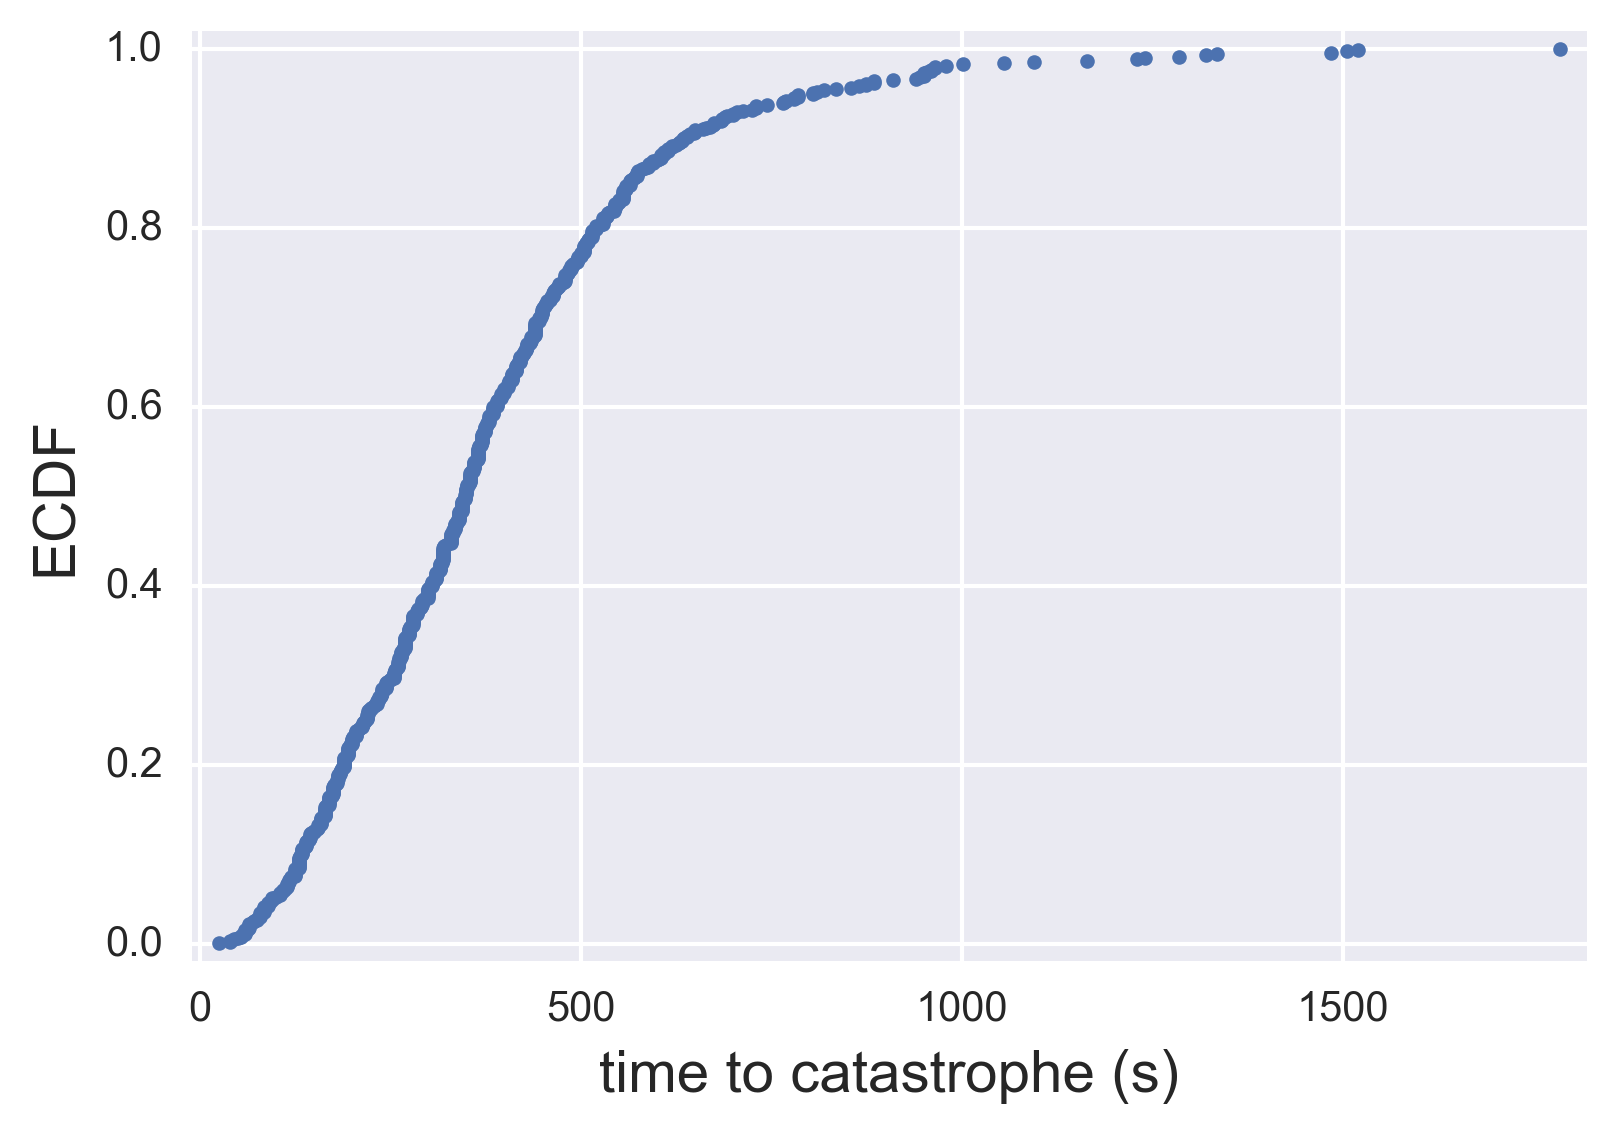

In [4]:
x, y = bebi103.ecdf(t)
plt.plot(x, y, marker='.', linestyle='none')
plt.margins(0.02)
plt.xlabel('time to catastrophe (s)')
plt.ylabel('ECDF');

Because of the inflection point, this definitely does not look to be Exponentially distributed. Despite already drawing a conclusion from the "eye test," it is worthwhile to check to see if an Occam factor might overwhelm the goodness of fit, so we will proceed with model selection. To do so, we first code up the log likelihood, log prior, and log posterior of each model. First, I write the log likelihoods in convenient form for coding up. We define

\begin{align}
n &= |D|, \\[1em]
T &= \sum_{i\in D} t_i,\\[1em]
T_\mathrm{ln} &=  \sum_{i\in D} \ln t_i.
\end{align}

Then,

\begin{align}
\ln P(D\mid \tau, M_1, I) &= -n\ln \tau - \frac{T}{\tau} \\[1em]
\ln P(D\mid \tau, a, M_2, I) &= - n(a\ln \tau + \ln \Gamma(a)) + (a-1)T_\mathrm{ln} - \frac{T}{\tau},\\[1em]
\ln P(D\mid \tau, \beta, M_3, I) &= -n(\beta\ln \tau - \ln \beta) + (\beta-1)T_\mathrm{ln} - \frac{1}{\tau^\beta}\sum_{i\in D} t_i^\beta.
\end{align}

Importantly, in the Exponential and Gamma distributions, the data only enter as sums or sums of logs. Taking advantage of this by pre-computing these properties of the data can greatly speed up the evaluation of the likelihood. Let's demonstrate with the Gamma distribution.

In [5]:
@numba.jit(nopython=True)
def log_like_gamma_slow(p, t):
    """
    Log likelihood for Gamma distributed MT catastrophes.
    """
    tau, a = p
    return -np.sum(t) / tau - len(t) * (a * np.log(tau) + math.lgamma(a)) \
                + (a-1) * np.sum(np.log(t))

    
@numba.jit(nopython=True)
def log_like_gamma(p, sum_t, sum_log_t, n):
    """
    Log likelihood for Gamma distributed MT catastrophes.
    """
    tau, a = p
    return -sum_t / tau - n * (a * np.log(tau) + math.lgamma(a)) \
                + (a-1) * sum_log_t

# Now do speed test
sum_t = np.sum(t)
sum_log_t = np.sum(np.log(t))
n = len(t)

%timeit log_like_gamma_slow(np.array([100.0, 3.0]), t)
%timeit log_like_gamma(np.array([100.0, 3.0]), sum_t, sum_log_t, n)

The slowest run took 31882.87 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 9.4 µs per loop
The slowest run took 22457.53 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 2.08 µs per loop


This is a speed boost of  more than a factor of four. We'll take it! (Coincidentally, I checked, and JITting accounts for another factor of two or three speed boost.) Now, we'll code up the other likelihoods.

In [6]:
@numba.jit(nopython=True)
def log_like_exp(p, sum_t, n):
    """
    Log likelihood for MT catastrophies being Exponentially distributed.
    """
    tau = p[0]
    return -sum_t / tau - n * np.log(tau)
    
@numba.jit(nopython=True)
def log_like_weibull(p, t, sum_log_t, n):
    """
    Log likelihood for MT catastrophies being Weibull distributed.
    """
    tau, beta = p
    return -np.sum(t**beta) / tau**beta - n * (beta * np.log(tau) - np.log(beta)) \
                + (beta-1) * sum_log_t

Now that we have the likelihoods, we can code up the priors. We will take Jeffreys priors on $\tau$ and $\beta$, and a uniform prior on $a$. For clarity, since we will take the parameters to be independent a priori, we will write a separate prior function for each parameter and then use them in the prior for each model.

In [7]:
@numba.jit(nopython=True)
def log_prior_tau(tau, tau_min, tau_max):
    """
    Log prior for tau.
    """
    if not (tau_min <= tau <= tau_max):
        return -np.inf
    return -np.log(tau) - np.log(np.log(tau_max / tau_min))


@numba.jit(nopython=True)
def log_prior_a(a, a_min, a_max):
    """
    Log prior for a.
    """
    if not (a_min <= a <= a_max):
        return -np.inf
    return -np.log(a_max - a_min)


@numba.jit(nopython=True)
def log_prior_beta(beta, beta_min, beta_max):
    """
    Log prior for beta.
    """
    if not (beta_min <= beta <= beta_max):
        return -np.inf
    return -np.log(beta) - np.log(np.log(beta_max / beta_min))


@numba.jit(nopython=True)
def log_prior_exp(p, tau_min, tau_max):
    return log_prior_tau(p[0], tau_min, tau_max)


@numba.jit(nopython=True)
def log_prior_gamma(p, tau_min, tau_max, a_min, a_max):
    return log_prior_tau(p[0], tau_min, tau_max) \
                + log_prior_a(p[1], a_min, a_max)

    
@numba.jit(nopython=True)
def log_prior_weibull(p, tau_min, tau_max, beta_min, beta_max):
    return log_prior_tau(p[0], tau_min, tau_max) \
                + log_prior_beta(p[1], beta_min, beta_max)

Finally, to perform the optimization, we can code up the negative log posterior, which is the objective function. We cast the return values as `numpy.float64` because of a bug in statsmodels's `approx_hess()` function that (unnecessarily) requires this data type.

In [8]:
@numba.jit(nopython=True)
def neg_log_posterior_exp(p, sum_t, n, tau_min, tau_max):
    """
    Negative log posterior or Exponential model.
    """
    lp = log_prior_exp(p, tau_min, tau_max)
    if lp == -np.inf:
        return np.inf
    return -lp - log_like_exp(p, sum_t, n)


@numba.jit(nopython=True)
def neg_log_posterior_gamma(p, sum_t, sum_log_t, n, tau_min, tau_max, 
                            a_min, a_max):
    """
    Negative log posterior or Gamma model.
    """
    lp = log_prior_gamma(p, tau_min, tau_max, a_min, a_max)
    if lp == -np.inf:
        return np.inf
    return -lp - log_like_gamma(p, sum_t, sum_log_t, n)


@numba.jit(nopython=True)
def neg_log_posterior_weibull(p, t, sum_log_t, n, tau_min, tau_max,
                              beta_min, beta_max):
    """
    Negative log posterior or Weibull model.
    """
    lp = log_prior_weibull(p, tau_min, tau_max, beta_min, beta_max)
    if lp == -np.inf:
        return np.inf
    return np.float64(-lp - log_like_weibull(p, t, sum_log_t, n))

Now, we need to specify the prior parameters, which are the bounds on the respective parameters. For $\tau$, we take $5 \text{ seconds} \le \tau \le 30 \text{ minutes}$. We choose these bounds because images were taken every five seconds, which is the fastest resolution time of the experiment. The experiment runs for 30 total minues, so we set that to be the maximum. We also take $1 \le a \le 30$. The lower bound means that at least one Poisson process must arrive for catastrophe, and the upper bound of 30 came from the following reasoning. $a = 10$ seems like a really high value for $a$, but still within the realm of possibility. $a = 100$ seems impossibly large, so we split the difference and choose the (approximate) geometric mean of 10 and 100. Finally, we take $0.1 \le \beta \le 10$, an apparently large range for $\beta$.

In [9]:
# Prior parameters
tau_min = 5.0
tau_max = 30.0 * 60
a_min = 1.0
a_max = 30.0
beta_min = 0.1
beta_max = 10.0

Now we finally have the pieces to do the optimization. For each, we compute the optimal parameter set and also the covariance matrix describing the Gaussian approximation of the posterior.

In [10]:
# Initial guesses
tau_0 = 400.0
a_0 = 2.0
beta_0 = 2.0

# Get optimal parameters for each
like_args_exp = (sum_t, n)
prior_args_exp = (tau_min, tau_max)
args_exp = like_args_exp + prior_args_exp
popt_exp = scipy.optimize.minimize(neg_log_posterior_exp, 
                                   np.array([tau_0]), 
                                   args=args_exp).x

like_args_gamma = (sum_t, sum_log_t, n)
prior_args_gamma = (tau_min, tau_max, a_min, a_max)
args_gamma = like_args_gamma + prior_args_gamma
popt_gamma = scipy.optimize.minimize(neg_log_posterior_gamma, 
                                     np.array([tau_0, a_0]), 
                                     args=args_gamma).x

like_args_weibull = (t, sum_log_t, n)
prior_args_weibull = (tau_min, tau_max, beta_min, beta_max)
args_weibull = like_args_weibull + prior_args_weibull
popt_weibull = scipy.optimize.minimize(neg_log_posterior_weibull, 
                                       np.array([tau_0, beta_0]), 
                                       args=args_weibull).x

# Compute posterior covariance matrices for each
cov_exp = np.linalg.inv(bebi103.approx_hess(
                popt_exp, neg_log_posterior_exp, args=args_exp))

cov_gamma = np.linalg.inv(bebi103.approx_hess(
                popt_gamma, neg_log_posterior_gamma, args=args_gamma))

cov_weibull = np.linalg.inv(bebi103.approx_hess(
                popt_weibull, neg_log_posterior_weibull, args=args_weibull))

Let's now look at the parameter values and their error bars (± one stardard deviation).

In [11]:
print("""
Exponential:
τ = {0:.0f} ± {1:.0f} seconds""".format(popt_exp[0], np.sqrt(cov_exp[0,0])))

print("""
Gamma:
τ = {0:.0f} ± {2:.0f} seconds
a = {1:.2f} ± {3:.2f}""".format(
        *popt_gamma, *np.sqrt(np.array([cov_gamma[0,0], cov_gamma[1,1]]))))

print("""
Weibull:
τ = {0:.0f} ± {2:.0f} seconds
β = {1:.2f} ± {3:.2f}""".format(
        *popt_weibull, *np.sqrt(np.array([cov_weibull[0,0], cov_weibull[1,1]]))))


Exponential:
τ = 380 ± 14 seconds

Gamma:
τ = 130 ± 7 seconds
a = 2.92 ± 0.15

Weibull:
τ = 429 ± 10 seconds
β = 1.75 ± 0.05


**c)** Now that we have our best fit parameters, let's plot the theoretical CDFs on the ECDF.

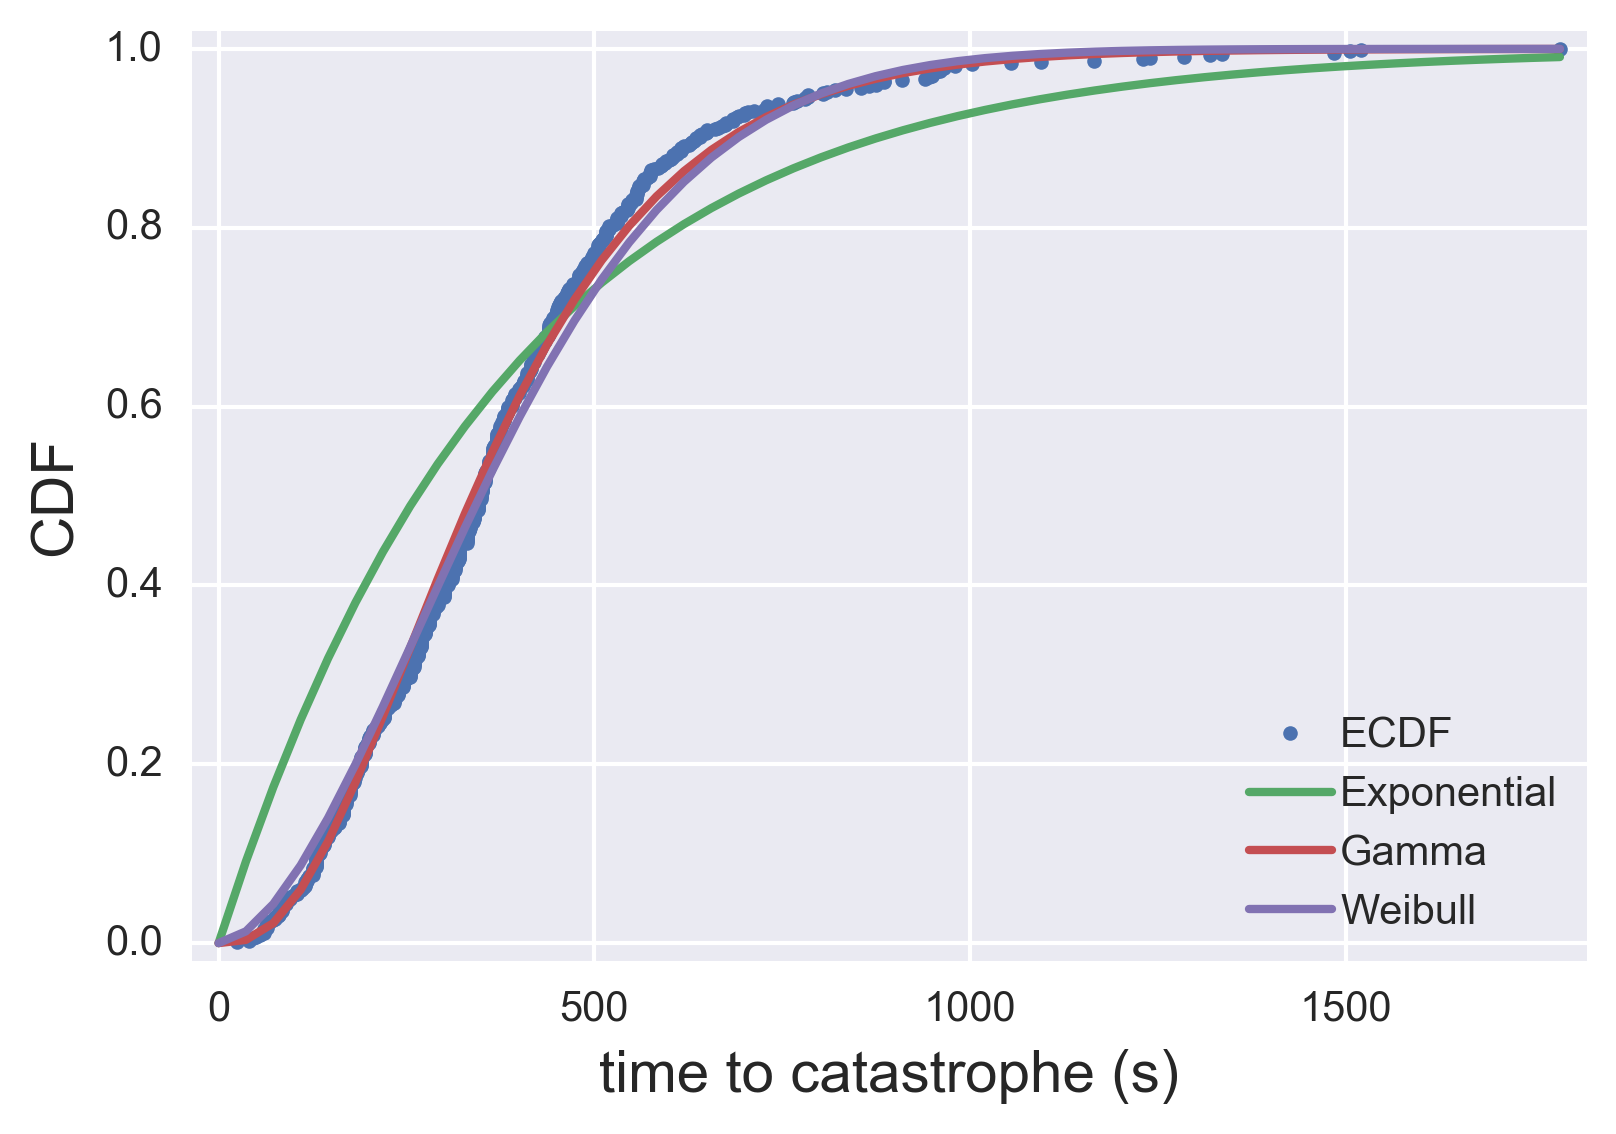

In [12]:
# Data points for smooth curve
x_smooth = np.linspace(0, t.max())

# Plot ECDF
plt.plot(x, y, marker='.', linestyle='none')

# Each best-estimate
plt.plot(x_smooth, st.expon.cdf(x_smooth, scale=popt_exp[0]), '-')
plt.plot(x_smooth, st.gamma.cdf(x_smooth, popt_gamma[1], scale=popt_gamma[0]), '-')
plt.plot(x_smooth, st.weibull_min.cdf(x_smooth, popt_weibull[1], 
                                      scale=popt_weibull[0]), '-')

# Pretty up plot
plt.margins(0.02)
plt.legend(('ECDF', 'Exponential', 'Gamma', 'Weibull'), loc='lower right')
plt.xlabel('time to catastrophe (s)')
plt.ylabel('CDF');

Clearly the Exponential distribution suffers from a goodness-of-fit problem. We'll look at this rigorously when we do the model selection. The Gamma and Weibull models do not appear to be that different, though both seem to have some systematic differences from the ECDF at intermediate catastrophe times.

**d)** As a reminder, the approximate odds ratio between models $M_i$ and $M_j$ having parameter sets $\mathbf{a}_i$ and $\mathbf{a}_j$, respectively, is

\begin{align}
O_{ij} \approx \left(\frac{P(M_i\mid I)}{P(M_j\mid I)}\right)
\left(\frac{P(D\mid \mathbf{a}_i^*, M_i, I)}{P(D\mid \mathbf{a}_j^*, M_j, I)}\right)
\left(\frac{P(\mathbf{a}_i^* \mid M_i, I) \,(2\pi)^{|\mathbf{a}_i|/2}\,\sqrt{\det\boldsymbol{\sigma}_i^2}}
{P(\mathbf{a}_j^*\mid M_j, I)\,(2\pi)^{|\mathbf{a}_j|/2} \sqrt{\det\boldsymbol{\sigma}_j^2}}\right),
\end{align}

where asterisks represent most probable parameter values. For this analysis, we assume equal a priori probability of all models, so

\begin{align}
\frac{P(M_i\mid I)}{P(M_j\mid I)} = 1.
\end{align}

We can then compute the likelihood ratio, which is a measure of goodness of fit.

In [13]:
# Exp / Gamma
log_goodfit_exp_gamma = log_like_exp(popt_exp, *like_args_exp) \
                    - log_like_gamma(popt_gamma, *like_args_gamma)
print('log10 goodness of fit exp/gamma:', log_goodfit_exp_gamma / np.log(10))

# Weibull / Gamma
log_goodfit_weibull_gamma = log_like_weibull(popt_weibull, *like_args_weibull) \
                    - log_like_gamma(popt_gamma, *like_args_gamma)
print('log10 goodness of fit weibull/gamma:', 
      log_goodfit_weibull_gamma / np.log(10))

log10 goodness of fit exp/gamma: -72.2799606734
log10 goodness of fit weibull/gamma: -7.53575211167


Wow! The goodness of fit ratio is $10^{-72}$ in favor of the Gamma distribution over the Exponential and $10^{-7}$ in favor of the Gamma distribution over Weibull. The Occam factors have a lot of work to do to overcome that. Let's compute the Occam factors.

In [14]:
def log_occam(log_prior_1, popt_1, prior_args_1, cov_1,
              log_prior_2, popt_2, prior_args_2, cov_2):
    """
    Compute approximate log Occam factor.
    """    
    log_prior_ratio = log_prior_1(popt_1, *prior_args_1) \
                                - log_prior_2(popt_2, *prior_args_2)
    log_dets = (np.log(np.linalg.det(cov_1)) - np.log(np.linalg.det(cov_2))) / 2
    log_2pi_ratio = (len(popt_1) - len(popt_2)) * np.log(2 * np.pi)
    return log_prior_ratio + log_dets + log_2pi_ratio

# Occam factor for exp/gamma
log_occam_exp_gamma = log_occam(
                log_prior_exp, popt_exp, prior_args_exp, cov_exp,
                log_prior_gamma, popt_gamma, prior_args_gamma, cov_gamma)

# Occam factor for weibull/gamma
log_occam_weibull_gamma = log_occam(
                log_prior_weibull, popt_weibull, prior_args_weibull, cov_weibull,
                log_prior_gamma, popt_gamma, prior_args_gamma, cov_gamma)

# Print results
print('log10 Occam factor exp/gamma:', log_occam_exp_gamma / np.log(10))
print('log10 Occam factor weibull/gamma:', log_occam_weibull_gamma / np.log(10))

log10 Occam factor exp/gamma: 1.72419361921
log10 Occam factor weibull/gamma: 0.0582979221799


So, the Occam factor favors Exponential over Gamma, but Gamma and Weibull are nearly equal. The Occam factors barely make a dent in the goodness of fit, so the odds ratios are large. Let's compute them.

In [15]:
print('odds ratio exp/gamma:', 
      np.exp(log_goodfit_exp_gamma + log_occam_exp_gamma))
print('odds ratio weibull/gamma:', 
      np.exp(log_goodfit_weibull_gamma + log_occam_weibull_gamma))

odds ratio exp/gamma: 2.78120464344e-71
odds ratio weibull/gamma: 3.33077894374e-08


So, the Gamma distribution is overwhelmingly favored.

**e)** We will not repeat the calculation using PTMCMC. The implementation is straightforward now that we have already coded up the log likelihoods and log priors. We start by performing PTMCMC for the exponential distribution, model $M_1$.

In [16]:
# Set MCMC parameters
n_burn = 5000
n_steps = 5000
n_walkers = 50
n_temps = 20

# Initialize parameter values
p_dict = collections.OrderedDict(
    [('tau', (np.random.uniform, (200.0, 400.0)))])

# Let 'er rip!
df_exp, lnZ_exp, dlnZ_exp = bebi103.run_pt_emcee(
            log_like_exp, log_prior_exp, n_burn, n_steps, n_temps=n_temps,
            n_walkers=n_walkers, p_dict=p_dict, loglargs=like_args_exp, 
            logpargs=prior_args_exp, return_lnZ=True)

Now for the Gamma distribution....

In [17]:
# Initialize parameter values
p_dict = collections.OrderedDict(
    [('tau', (np.random.uniform, (200.0, 400.0))),
     ('a', (np.random.uniform, (1.0, 4.0)))])

# Let 'er rip!
df_gamma, lnZ_gamma, dlnZ_gamma = bebi103.run_pt_emcee(
            log_like_gamma, log_prior_gamma, n_burn, n_steps, n_temps=n_temps,
            n_walkers=n_walkers, p_dict=p_dict, loglargs=like_args_gamma, 
            logpargs=prior_args_gamma, return_lnZ=True)

And the Weibull....

In [18]:
# Initialize parameter values
p_dict = collections.OrderedDict(
    [('tau', (np.random.uniform, (200.0, 400.0))),
     ('b', (np.random.uniform, (1.0, 2.0)))])

# Let 'er rip!
df_weibull, lnZ_weibull, dlnZ_weibull = bebi103.run_pt_emcee(
            log_like_weibull, log_prior_weibull, n_burn, n_steps, n_temps=n_temps,
            n_walkers=n_walkers, p_dict=p_dict, loglargs=like_args_weibull, 
            logpargs=prior_args_weibull, return_lnZ=True)

Now that we have all of the $\ln Z$ values for the respective models, we can compute the odds ratios.

In [20]:
print('odds ratio exp/gamma:', np.exp(lnZ_exp - lnZ_gamma))
print('odds ratio weibull/gamma:', np.exp(lnZ_weibull - lnZ_gamma))

odds ratio exp/gamma: 9.90216375626e-72
odds ratio weibull/gamma: 3.04815005904e-08


These are very close to the results using optimization and the Laplace approximation.

**f)** Going forward, we will use the Gamma distribution to describe MT catastrophe observations. We will perform parameter estimation by ensemble MCMC.

In [136]:
@numba.jit(nopython=True)
def log_posterior_gamma(p, sum_t, sum_log_t, n, tau_min, tau_max, 
                        a_min, a_max):
    """
    Log posterior gor Gamma model.
    """
    return -neg_log_posterior_gamma(p, sum_t, sum_log_t, n, tau_min, tau_max, 
                        a_min, a_max)


def sample_mcmc(t, n_burn=20000, n_steps=10000, n_walkers=50):
    """
    Given array of catastrophe times, perform MCMC to get mode/HPD for
    parameters a and tau.
    """
    
    # Initialize parameter values
    p_dict = collections.OrderedDict(
        [('tau', (np.random.uniform, (200.0, 400.0))),
         ('a', (np.random.uniform, (1.0, 4.0)))])

    # Set up arguments
    like_args = (np.sum(t), np.sum(np.log(t)), len(t))
    prior_args = (tau_min, tau_max, a_min, a_max)
    args = like_args + prior_args
    
    # Let 'er rip!
    df_mcmc = bebi103.run_ensemble_emcee(log_posterior_gamma, n_burn, n_steps, 
                                   n_walkers=n_walkers, p_dict=p_dict, args=args)

    # Compute mode and HPD
    mode_ind = np.where(
        np.isclose(df_mcmc['lnprob'], df_mcmc['lnprob'].max()))[0][0]
    mode_a = df_mcmc.loc[mode_ind, 'a']
    mode_tau = df_mcmc.loc[mode_ind, 'tau']
    hpd_a = bebi103.hpd(df_mcmc['a'].values, 0.95)
    hpd_tau = bebi103.hpd(df_mcmc['tau'].values, 0.95)
    
    return mode_a, mode_tau, hpd_a, hpd_tau

With the sampling function in hand, we can make out estimates for each concentration.

In [137]:
# Build concentrations
concs = np.array([float(col.split(' ')[0]) for col in df.columns])

# Initialize dictionary of results (thinking ahead to part (g))
results = {'no_motor': {'mode_a': [], 'mode_tau': [], 'hpd_a': [], 'hpd_tau': [],
                        'concs': concs}}

# Make calculations
for i, col in enumerate(df.columns):
    mode_a, mode_tau, hpd_a, hpd_tau = sample_mcmc(df[col].dropna().values)
    results['no_motor']['mode_a'].append(mode_a)
    results['no_motor']['mode_tau'].append(mode_tau)
    results['no_motor']['hpd_a'].append(hpd_a)
    results['no_motor']['hpd_tau'].append(hpd_tau)

# Convert to NumPy arrays    
for key in results['no_motor']:
    results['no_motor'][key] = np.array(results['no_motor'][key])

Now we can make a plot.

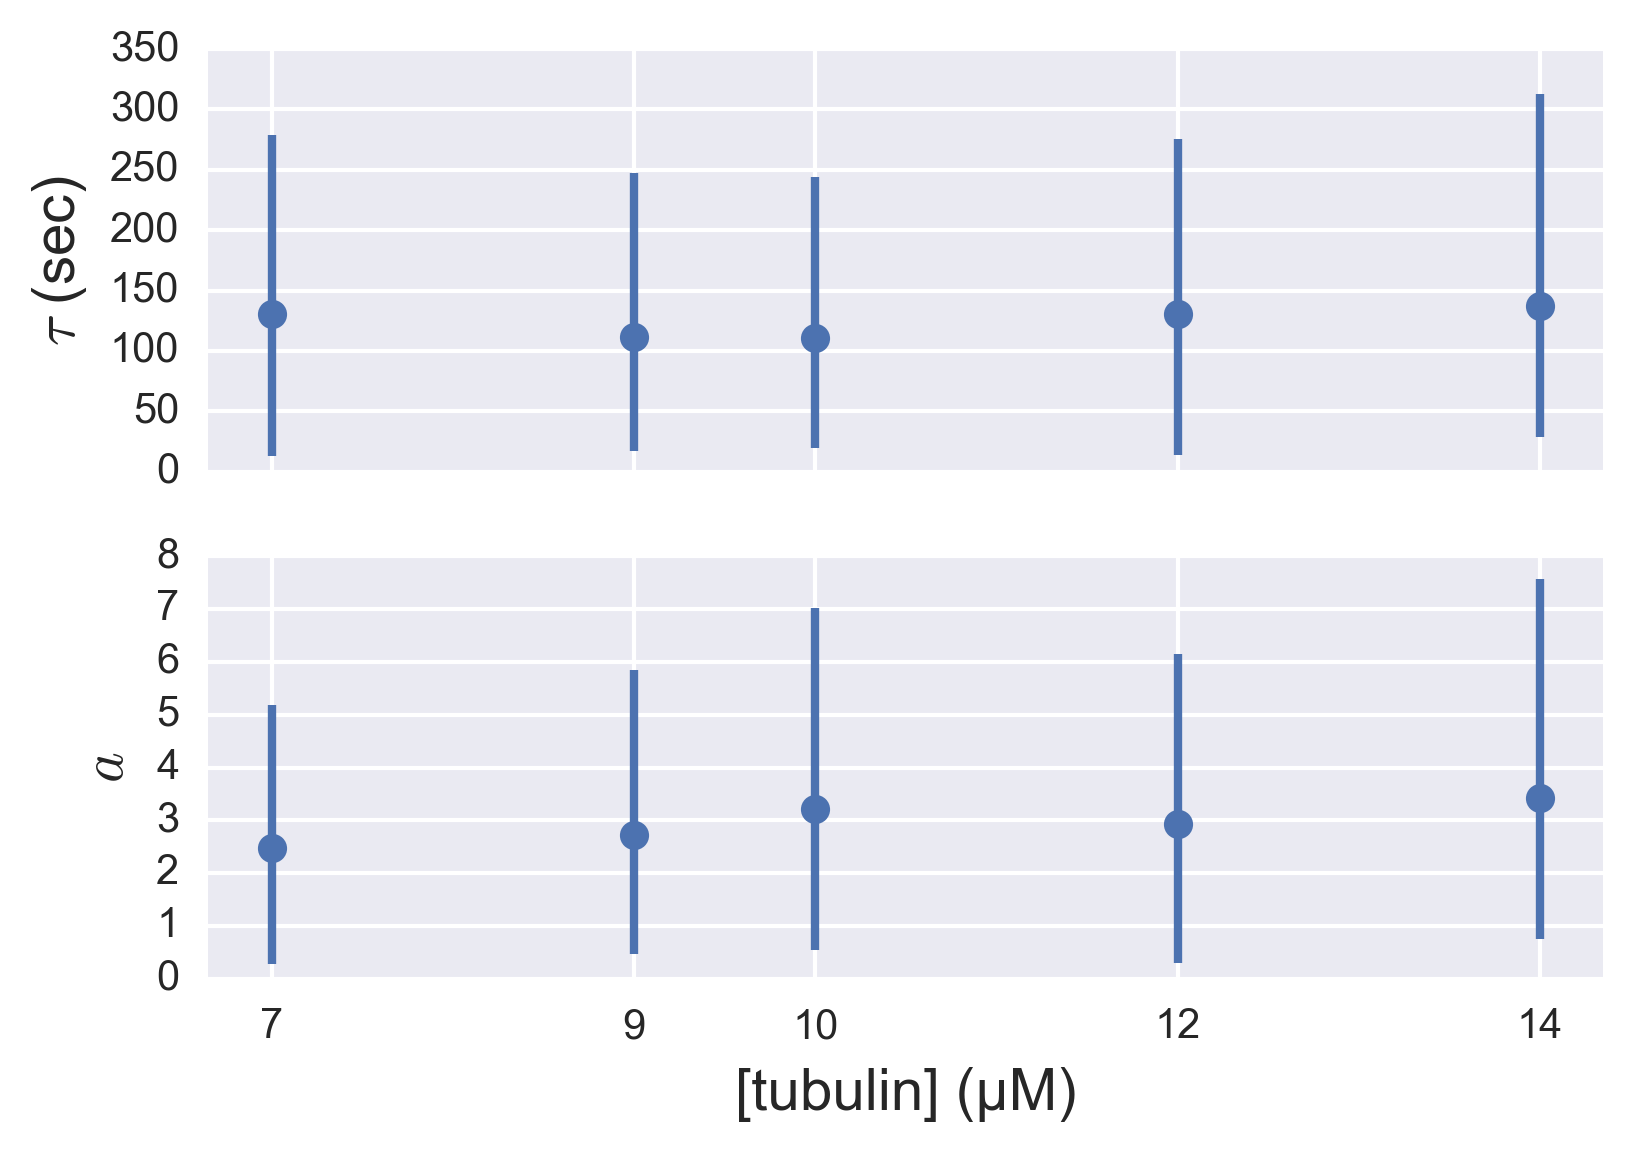

In [138]:
fig, ax = plt.subplots(2, 1, sharex=True)
d = results['no_motor']
ax[0].errorbar(d['concs'], d['mode_tau'], yerr=d['hpd_tau'].T, 
               marker='o', linestyle='none')
ax[1].errorbar(d['concs'], d['mode_a'], yerr=d['hpd_a'].T, 
               marker='o', linestyle='none');
ax[0].margins(x=0.05)
ax[0].set_ylabel(r'$\tau$ (sec)')
ax[1].set_ylabel(r'$a$')
ax[1].set_xlabel('[tubulin] (µM)')
ax[1].set_xticks(concs);

In [127]:
np.hstack((d['hpd_a'][0,:].reshape(2,1), d['hpd_a'].T))

array([[ 2.63168574,  2.63168574,  2.19590635,  2.25893311,  2.66172781,
         2.64897393],
       [ 3.21494606,  3.21494606,  2.71357246,  3.13534133,  3.79809834,
         4.14382138]])

There is very little variation between tubulin concentrations in the rate of catastrophe and in $a$, the number of processes. Thus, microtubule catastrophe rates are independent of tubulin concentration. Because microtubules grow faster with more tubulin, catastrophe is also independent of microtubule length.

**g)** 

In [128]:
# Read in data
df_kip3 = pd.read_csv('../data/gardner_mt_catastrophe_kip3.csv', comment='#')
df_mcak = pd.read_csv('../data/gardner_mt_catastrophe_mcak.csv', comment='#')

# Get concentrations
concs_kip3 = np.array([float(col.split(' ')[0]) for col in df_kip3.columns])
concs_mcak = np.array([float(col.split(' ')[0]) for col in df_mcak.columns])

# Initialize outputs
results['kip3'] = {'mode_a': [], 'mode_tau': [], 'hpd_a': [], 'hpd_tau': [],
                        'concs': concs_kip3}
results['mcak'] = {'mode_a': [], 'mode_tau': [], 'hpd_a': [], 'hpd_tau': [],
                        'concs': concs_mcak}

# Make calculations
for motor, df_motor in zip(['kip3', 'mcak'], [df_kip3, df_mcak]):
    for i, col in enumerate(df_motor.columns):
        mode_a, mode_tau, hpd_a, hpd_tau = sample_mcmc(
                                    df_motor[col].dropna().values)
        results[motor]['mode_a'].append(mode_a)
        results[motor]['mode_tau'].append(mode_tau)
        results[motor]['hpd_a'].append(hpd_a)
        results[motor]['hpd_tau'].append(hpd_tau)

    # Convert to NumPy arrays    
    for key in results[motor]:
        results[motor][key] = np.array(results[motor][key])

Now, we can plot the values of the parameters vs. the Kip3 and MCAK concentrations. First, Kip3.

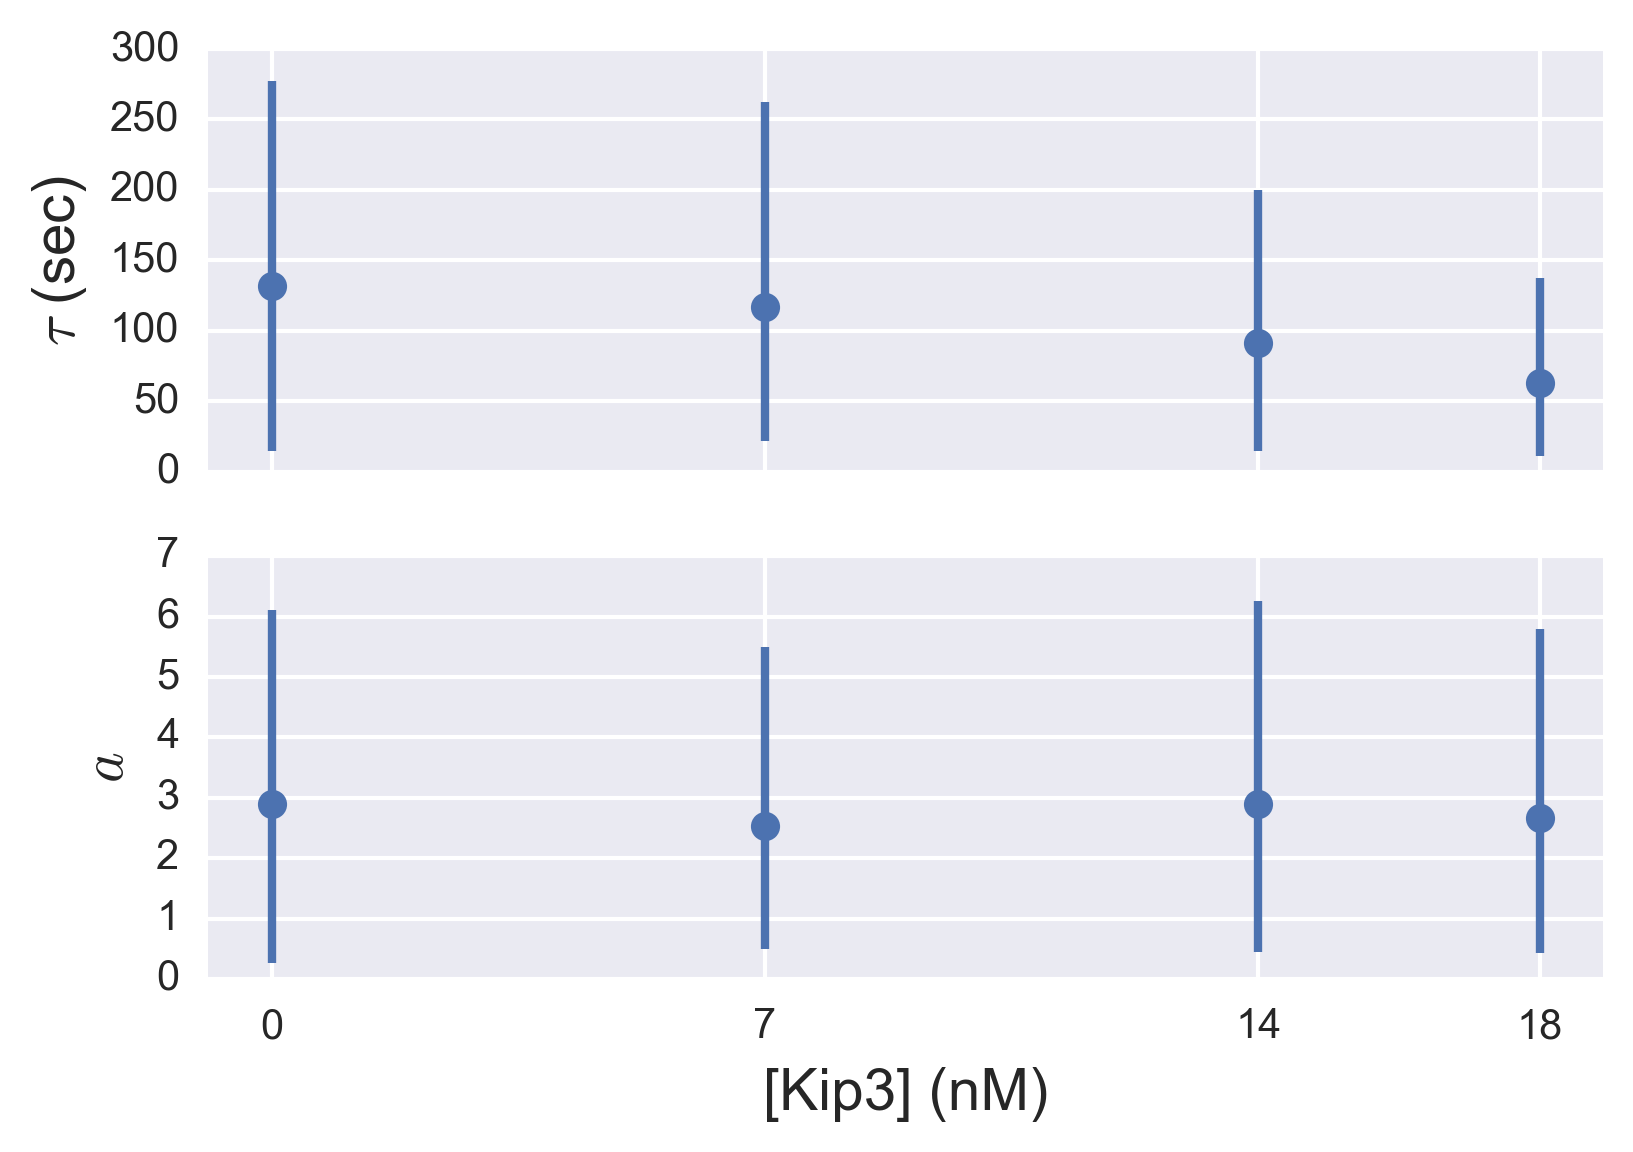

In [135]:
fig, ax = plt.subplots(2, 1, sharex=True)
d = results['no_motor']
x = np.concatenate(((0,), results['kip3']['concs']))
a = np.concatenate(((results['no_motor']['mode_a'][0],), 
                    results['kip3']['mode_a']))
tau = np.concatenate(((results['no_motor']['mode_tau'][0],), 
                      results['kip3']['mode_tau']))
aerr = np.hstack(((results['no_motor']['hpd_a'][0,:].reshape(2,1), 
                   results['kip3']['hpd_a'].T)))
tauerr = np.hstack(((results['no_motor']['hpd_tau'][0,:].reshape(2,1), 
                   results['kip3']['hpd_tau'].T)))

ax[0].errorbar(x, tau, tauerr, marker='o', linestyle='none')
ax[1].errorbar(x, a, aerr, marker='o', linestyle='none')
ax[0].margins(x=0.05)
ax[0].set_ylabel(r'$\tau$ (sec)')
ax[1].set_ylabel(r'$a$')
ax[1].set_xlabel('[Kip3] (nM)')
ax[1].set_xticks(x);

We do not see a substantial change in the parameter $a$ as a function of Kip3 concentration, which suggests that the number of processes necessary for catastrophe is unchanged by Kip3, still being three. We do see a slight downward trend in the parameter $\tau$, especially toward larger Kip3 concentrations, suggesting that Kip3 might aid in bringing about catastrophe.

In [132]:
results['kip3']

{'concs': array([ 18.,  14.,   7.]),
 'hpd_a': array([[ 2.23662671,  3.12411955],
        [ 2.43999306,  3.36344349],
        [ 2.03070614,  2.97132504]]),
 'hpd_tau': array([[  51.60755519,   74.55383658],
        [  76.34858571,  108.58260673],
        [  95.15907032,  145.56865453]]),
 'mode_a': array([ 2.66522902,  2.89224146,  2.52597073]),
 'mode_tau': array([  62.83691379,   91.27063208,  117.04045792])}

In [124]:
results['no_motor']['hpd_a'][0,:].reshape(2,1)

array([[ 2.63168574],
       [ 3.21494606]])

In [112]:
d['mode_tau'][0]

131.70835654148408

In [102]:
concs

array([ 12.,   7.,   9.,  10.,  14.])

In [73]:
df_kip3

,18 nM Kip3,14 nM Kip3,7 nM Kip3
0,30.0,40,43.596
1,35.0,50,58.128
2,35.0,55,60.550
3,35.0,55,60.550
4,40.0,60,65.394
5,40.0,60,67.816
6,40.0,60,72.660
7,45.0,60,72.660
8,45.0,70,75.082
9,45.0,70,79.926


In [21]:
d

,12 uM,7 uM,9 uM,10 uM,14 uM
0,25.000,35.0,25.0,50.0,60.0
1,40.000,45.0,40.0,60.0,75.0
2,40.000,50.0,40.0,60.0,75.0
3,45.429,50.0,45.0,75.0,85.0
4,50.000,55.0,50.0,75.0,115.0
5,55.000,55.0,50.0,85.0,115.0
6,56.386,55.0,55.0,90.0,135.0
7,60.000,55.0,55.0,90.0,140.0
8,60.000,55.0,60.0,100.0,145.0
9,60.000,60.0,65.0,105.0,150.0


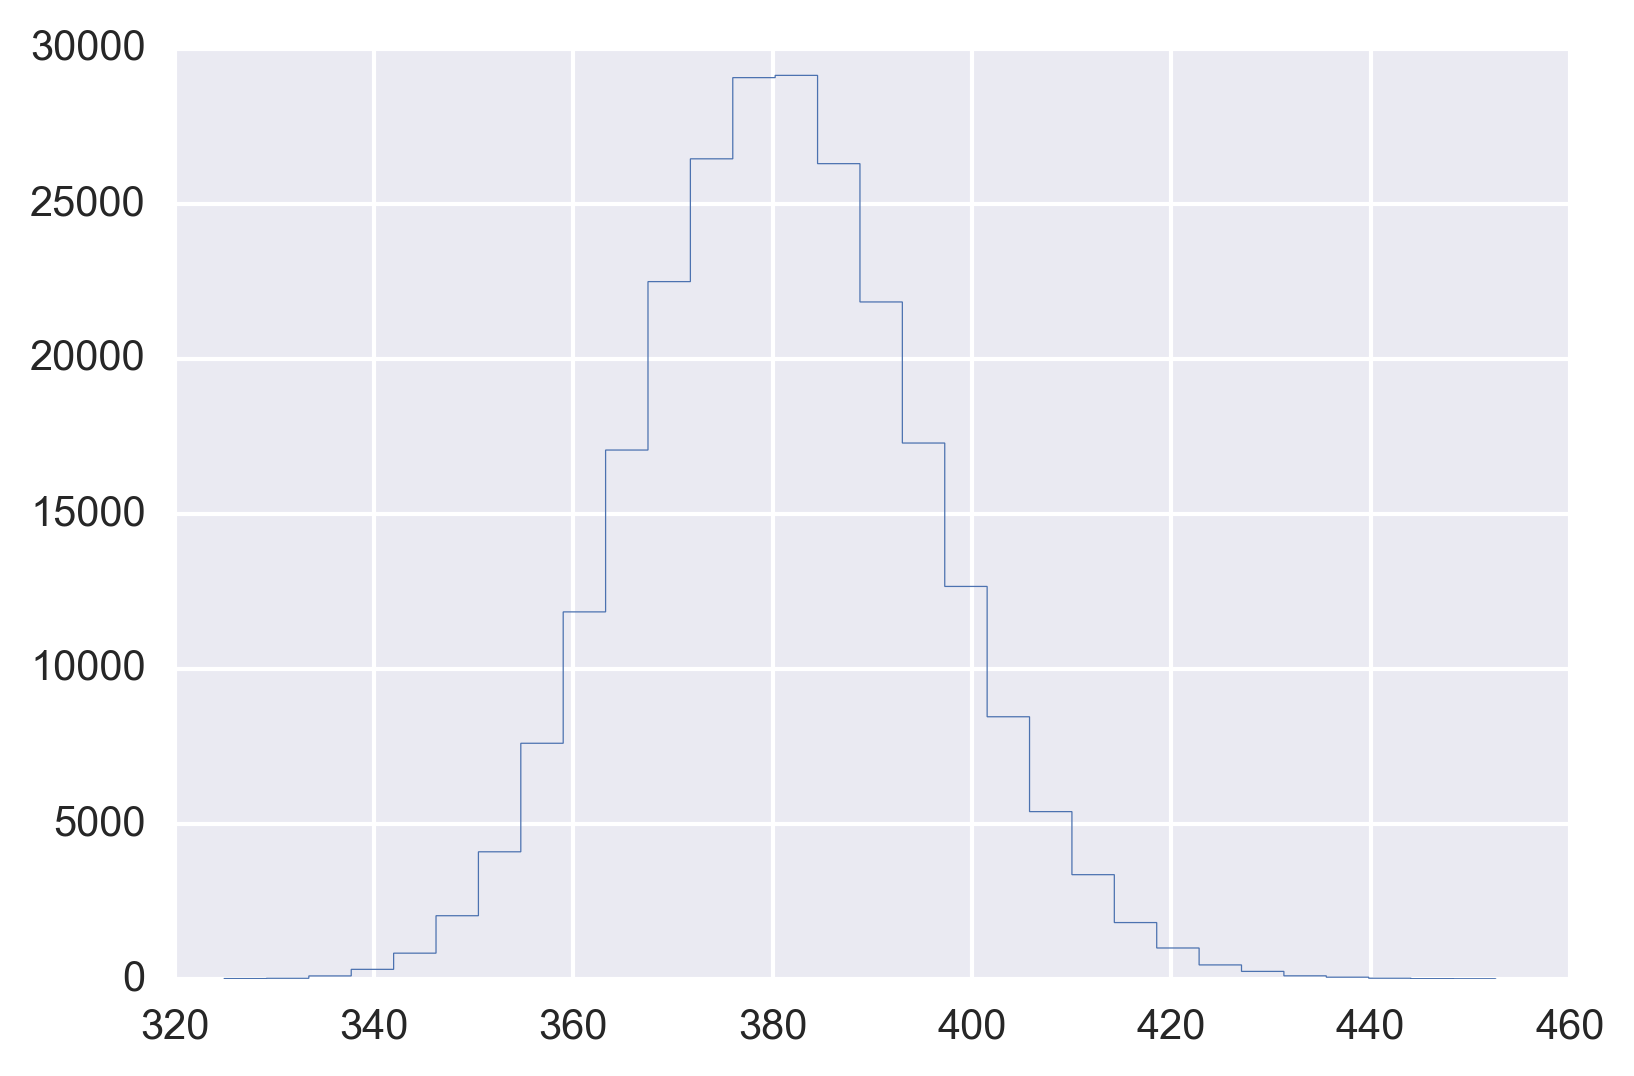

In [109]:
_ = plt.hist(df_exp.loc[df_exp.beta_ind==0, 'tau'], bins=30, histtype='step')

In [107]:
lnZ_exp

-4805.0604869390618

In [99]:
log_prior_exp(np.array([6.599628]), tau_min, tau_max)

-3.659607607851023

In [101]:
n_dim = 1
p0 = np.empty((n_temps, n_walkers, n_dim))
for i, key in enumerate(p_dict):
    p0[:, :, i] = p_dict[key][0](
        *(p_dict[key][1] + ((n_temps, n_walkers),)))


In [102]:
p0

array([[[ 200.33874786],
        [ 200.34702665],
        [ 200.81603644],
        [ 200.60454895],
        [ 200.71066414],
        [ 200.69364822],
        [ 200.75441894],
        [ 200.9589812 ],
        [ 200.3355016 ],
        [ 200.51038482],
        [ 200.64448037],
        [ 200.13074521],
        [ 200.36176582],
        [ 200.94216246],
        [ 200.57393079],
        [ 200.19199068],
        [ 200.23600156],
        [ 200.23102118],
        [ 200.86628244],
        [ 200.92254714],
        [ 200.39292456],
        [ 200.53331612],
        [ 200.21834911],
        [ 200.38026766],
        [ 200.83267012],
        [ 200.43076224],
        [ 200.93094581],
        [ 200.04497126],
        [ 200.29703122],
        [ 200.63461421],
        [ 200.42693767],
        [ 200.03031397],
        [ 200.29783981],
        [ 200.45547936],
        [ 200.5858709 ],
        [ 200.39513919],
        [ 200.1803643 ],
        [ 200.50452141],
        [ 200.78015557],
        [ 200.88038171],
